In [1]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import pandas as pd
from torch.utils.data import Dataset
import os

set_seed(123)

epochs = 16

batch_size = 16

max_length = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name_or_path = 'gpt2'

class_names = ['Alive','Dead']

labels_ids = {'Alive': 0, 'Dead': 1}

n_labels = len(labels_ids)

/ssd2/muntasir/Desktop/NJACTS/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


class EventDataset(Dataset):
    r"""PyTorch Dataset class for loading data.

    This is where the data parsing happens.

    This class is built with reusability in mind: it can be used as is as.

    Arguments:

    path (:obj:`str`):
        Path to the data CSV file.

    """

    def __init__(self, path,use_tokenizer):
        # Check if path exists.
        if not os.path.isfile(path):
            # Raise error if path is invalid.
            raise ValueError('Invalid `path` variable! Needs to be a file')
        
        # Load the CSV file.
        self.data = pd.read_csv(path)
        
        # Ensure the CSV file contains 'Content' and 'label' columns.
        if 'Text' not in self.data.columns or 'label' not in self.data.columns:
            raise ValueError("CSV file must contain 'Text' and 'label' columns.")
        
        self.texts = self.data['Text'].tolist()   # [:20] # for debugging
        self.labels = self.data['label'].tolist()    # [:20] # for debugging

        # Number of examples.
        self.n_examples = len(self.labels)

    def __len__(self):
        r"""When used `len` return the number of examples.

        """

        return self.n_examples

    def __getitem__(self, item):
        r"""Given an index return an example from the position.

        Arguments:

        item (:obj:`int`):
            Index position to pick an example to return.

        Returns:
        :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
        associated labels.

        """
        label_str = 'Dead' if self.labels[item] == 1 else 'Alive'

        return {'text': self.texts[item],
                'label': label_str}


In [3]:

class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_, class_weights):
    r"""
    Train pytorch model on a single pass through the data loader.

    It will use the global variable `model` which is the transformer model 
    loaded on `_device` that we want to train on.

    This function is built with reusability in mind: it can be used as is as long
      as the `dataloader` outputs a batch in dictionary format that can be passed 
      straight into the model - `model(**batch)`.

    Arguments:

        dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
            Parsed data into batches of tensors.

        optimizer_ (:obj:`transformers.optimization.AdamW`):
            Optimizer used for training.

        scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
            PyTorch scheduler.

        device_ (:obj:`torch.device`):
            Device used to load tensors before feeding to model.

        class_weights (:obj:`torch.FloatTensor`):
            Class weights to handle class imbalance.

    Returns:

        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
          Labels, Train Average Loss].
    """

    # Use global variable for model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Define the loss function with class weights
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):

        # Add original labels - use later for evaluation.
        true_labels += batch['labels'].numpy().flatten().tolist()
        
        # move batch to device
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
        
        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits.
        logits = outputs[1]  # Get logits

        # Calculate loss with class weights
        loss = loss_fn(logits, batch['labels'])

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer_.step()

        # Update the learning rate.
        scheduler_.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Convert these logits to list of predicted labels values.
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)
    
    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss




import torch
from tqdm import tqdm

def validation(dataloader, device_):
    r"""Validation function to evaluate model performance on a 
    separate set of data.

    This function will return the true and predicted labels, as well as the
    prediction probabilities, so we can use them later to evaluate the model's
    performance, including calculating the roc_auc score.

    This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
        Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
        Device used to load tensors before feeding to model.

    Returns:
    
    :obj:`Tuple[List[int], List[int], List[List[float]], float]`: Tuple of [True Labels, 
        Predicted Labels, Prediction Probabilities, Average Loss]
    """

    # Use global variable for model.
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    prediction_probs = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):

        # Add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()

        # Move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the 
            # loss value out of the tuple along with the logits. We will use logits
            # later to calculate training accuracy.
            loss, logits = outputs[:2]
            
            # Move logits to CPU
            logits = logits.detach().cpu().numpy()

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_loss += loss.item()
            
            # Apply softmax to get prediction probabilities
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
            
            # Get predictions
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # Update lists
            predictions_labels += predict_content
            prediction_probs += probs.tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return true labels, predicted labels, prediction probabilities, and average loss.
    return true_labels, predictions_labels, prediction_probs, avg_epoch_loss


In [4]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)

print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model...
Model loaded to `cuda`


In [5]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = EventDataset(path='Data/train.csv', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  EventDataset(path='Data/valid.csv', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

print('Dealing with Test...')
# Create pytorch dataset.
test_dataset =  EventDataset(path='Data/test.csv', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(test_dataloader))

Dealing with Train...
Created `train_dataset` with 941 examples!
Created `train_dataloader` with 59 batches!

Dealing with Validation...
Created `valid_dataset` with 118 examples!
Created `eval_dataloader` with 8 batches!
Dealing with Test...
Created `valid_dataset` with 118 examples!
Created `eval_dataloader` with 8 batches!


In [6]:
labels = pd.read_csv('Data/train.csv')['label']

In [7]:
type(labels)

pandas.core.series.Series

In [8]:
import torch
import numpy as np


labels = np.array(labels)  

# Compute the class weights
classes, class_sample_count = np.unique(labels, return_counts=True)
weight = 1. / class_sample_count
class_weights_dict = {cls: w for cls, w in zip(classes, weight)}

# Apply class weights to each sample's label
samples_weight = np.array([class_weights_dict[t] for t in labels])

class_weights = torch.FloatTensor([class_weights_dict[cls] for cls in classes]).to('cuda')

In [9]:
class_weights

tensor([0.0012, 0.0081], device='cuda:0')

In [10]:
test_dataset

In [11]:
train_dataset.__getitem__(0)

{'text': '\nThe information of the patient is:\nThe age is 72,\nThe gender is Male,\nThe BMI index is 37.59,\nThe patient is hypertensive: No,\nThe patient has atrial fibrillation: No,\nThe patient has Ischaemic heart disease: No,\nThe patient has diabetes: Yes,\nThe patient has Hypoferric anaemia: Yes,\nThe patient has depression: No,\nThe patient has Hyperlipemia: Yes,\nThe patient has Chronic renal insufficiency: Yes,\nThe patient has Chronic obstructive pulmonary disease: No,\nThe heart rate is 68.84,\nThe Systolic blood pressure is 155.87,\nThe Diastolic blood pressure is 68.33,\nThe Respiratory rate is 16.62,\nThe temperature is 36.71,\nThe saturation pulse oxygen is 98.39,\nThe Urine output in the first 24 hours is 2155.00,\nThe hematocrit is 26.27,\nThe red blood cell is 2.96,\nThe mean corpuscular hemoglobin is 28.25,\nThe mean corpuscular hemoglobin concentration is 31.52,\nThe mean corpuscular volume is 89.9,\nThe red cell distribution width is 16.22,\nThe Leucocyte is 7.65,

In [12]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device,class_weights)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, predict_probs, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)



/ssd2/muntasir/Desktop/NJACTS/.env/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch


  0%|          | 0/16 [00:00<?, ?it/s]


Training on batches...


100%|██████████| 59/59 [00:54<00:00,  1.09it/s]


Validation on batches...


  6%|▋         | 1/16 [00:56<14:08, 56.54s/it]

  train_loss: 1.08137 - val_loss: 1.12925 - train_acc: 0.54942 - valid_acc: 0.17797


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 12%|█▎        | 2/16 [01:50<12:53, 55.25s/it]

  train_loss: 0.72890 - val_loss: 0.67719 - train_acc: 0.48565 - valid_acc: 0.60169


Training on batches...


100%|██████████| 59/59 [00:52<00:00,  1.13it/s]


Validation on batches...


 19%|█▉        | 3/16 [02:45<11:53, 54.88s/it]

  train_loss: 0.70969 - val_loss: 0.48507 - train_acc: 0.59511 - valid_acc: 0.83898


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 25%|██▌       | 4/16 [03:39<10:55, 54.63s/it]

  train_loss: 0.71529 - val_loss: 0.79228 - train_acc: 0.58130 - valid_acc: 0.39831


Training on batches...


100%|██████████| 59/59 [00:52<00:00,  1.13it/s]


Validation on batches...


 31%|███▏      | 5/16 [04:34<10:00, 54.61s/it]

  train_loss: 0.67412 - val_loss: 0.67657 - train_acc: 0.64825 - valid_acc: 0.52542


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 38%|███▊      | 6/16 [05:28<09:05, 54.53s/it]

  train_loss: 0.64222 - val_loss: 0.85802 - train_acc: 0.69182 - valid_acc: 0.38136


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 44%|████▍     | 7/16 [06:22<08:10, 54.46s/it]

  train_loss: 0.66167 - val_loss: 0.64279 - train_acc: 0.62168 - valid_acc: 0.60169


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 50%|█████     | 8/16 [07:16<07:14, 54.36s/it]

  train_loss: 0.64966 - val_loss: 0.73418 - train_acc: 0.70032 - valid_acc: 0.53390


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 56%|█████▋    | 9/16 [08:11<06:20, 54.30s/it]

  train_loss: 0.58907 - val_loss: 0.58283 - train_acc: 0.72795 - valid_acc: 0.68644


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 62%|██████▎   | 10/16 [09:05<05:25, 54.20s/it]

  train_loss: 0.54301 - val_loss: 0.63552 - train_acc: 0.77258 - valid_acc: 0.66949


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.13it/s]


Validation on batches...


 69%|██████▉   | 11/16 [09:59<04:31, 54.26s/it]

  train_loss: 0.52114 - val_loss: 0.66081 - train_acc: 0.80659 - valid_acc: 0.66949


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 75%|███████▌  | 12/16 [10:53<03:36, 54.22s/it]

  train_loss: 0.50799 - val_loss: 0.73489 - train_acc: 0.77577 - valid_acc: 0.66949


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 81%|████████▏ | 13/16 [11:47<02:42, 54.22s/it]

  train_loss: 0.47643 - val_loss: 0.77418 - train_acc: 0.79702 - valid_acc: 0.63559


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 88%|████████▊ | 14/16 [12:41<01:48, 54.19s/it]

  train_loss: 0.46797 - val_loss: 0.65314 - train_acc: 0.81190 - valid_acc: 0.72034


Training on batches...


100%|██████████| 59/59 [00:51<00:00,  1.14it/s]


Validation on batches...


 94%|█████████▍| 15/16 [13:36<00:54, 54.21s/it]

  train_loss: 0.44760 - val_loss: 0.72409 - train_acc: 0.83953 - valid_acc: 0.66949


Training on batches...


100%|██████████| 59/59 [00:52<00:00,  1.13it/s]


Validation on batches...


100%|██████████| 16/16 [14:30<00:00, 54.42s/it]

  train_loss: 0.44284 - val_loss: 0.69344 - train_acc: 0.83953 - valid_acc: 0.69492



/ssd2/muntasir/Desktop/NJACTS/.env/lib/python3.10/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


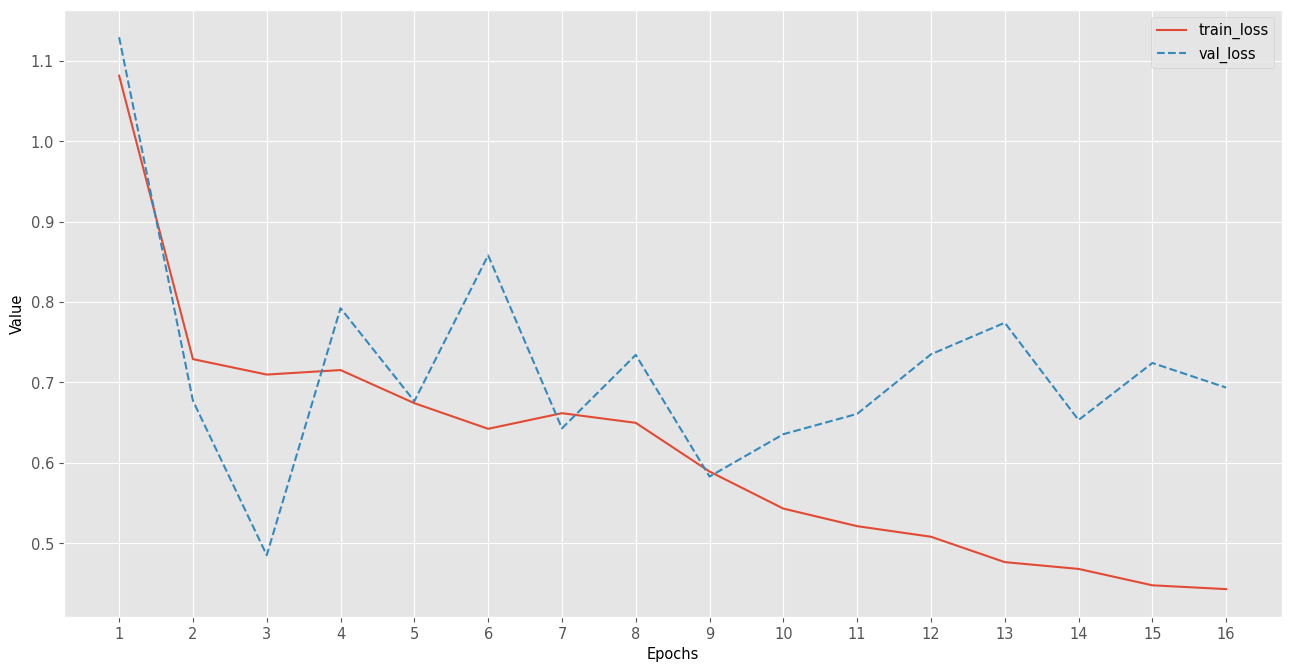

/ssd2/muntasir/Desktop/NJACTS/.env/lib/python3.10/site-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


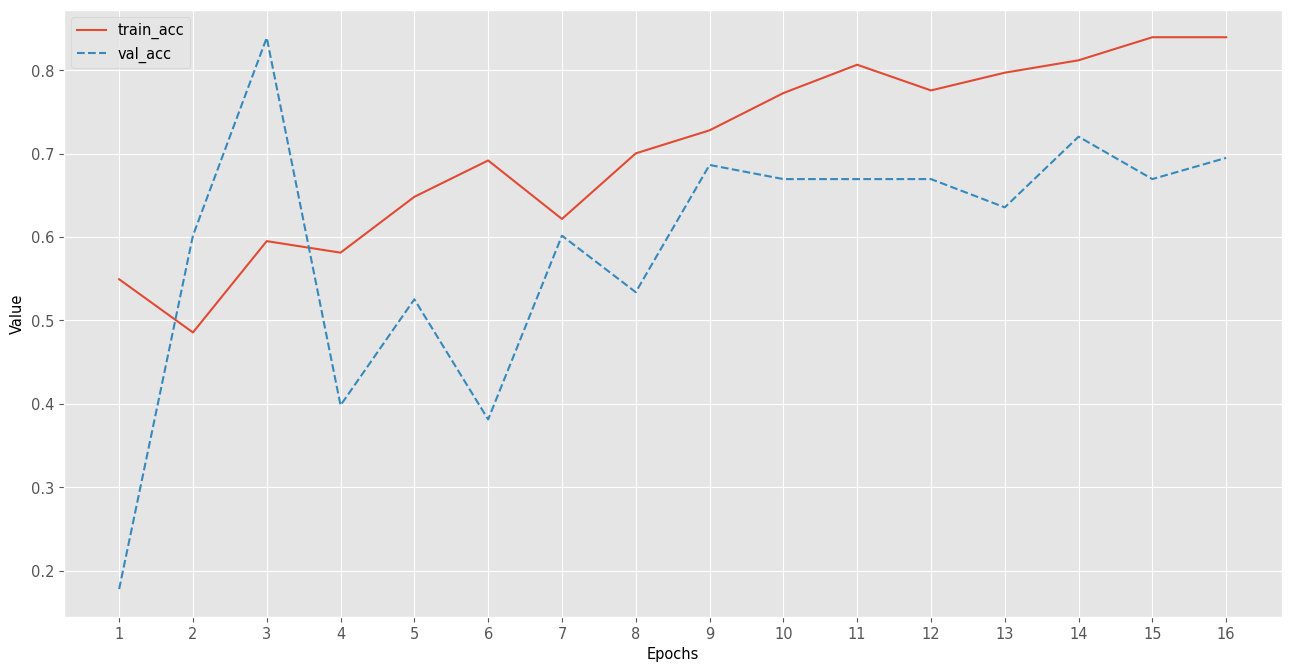

In [13]:
# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [14]:
help(plot_dict)

Help on function plot_dict in module ml_things.plot_functions:

plot_dict(dict_arrays, start_step=0, step_size=1, use_title=None, points_values=False, points_round=3, use_xlabel=None, use_xticks=True, use_rotation_xticks=0, xticks_labels=None, use_ylabel=None, style_sheet='ggplot', use_grid=True, use_linestyles=None, font_size=None, width=3, height=1, magnify=1.2, use_dpi=50, path=None, show_plot=True)
    Create plot from a single array of values.
    
    Arguments:
    
        dict_arrays (:obj:`dict([list])`):
            Dictionary of arrays that will get plotted. The keys in dictionary are used as labels and the values as
            arrays that get plotted.
    
        start_step (:obj:`int`, `optional`, defaults to :obj:`0`):
            Starting value of plot.This argument is optional and it has a default value attributed inside
            the function.
    
        step_size (:obj:`int`, `optional`, defaults to :obj:`q`):
            Steps shows on x-axis. Change if each s

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]


Evaluation Report:
              precision    recall  f1-score   support

       Alive       0.92      0.70      0.80       104
        Dead       0.21      0.57      0.30        14

    accuracy                           0.69       118
   macro avg       0.56      0.64      0.55       118
weighted avg       0.84      0.69      0.74       118


ROC AUC Score: 0.6627747252747253

True Positives: 8
True Negatives: 73
False Positives: 31
False Negatives: 6
Normalized confusion matrix


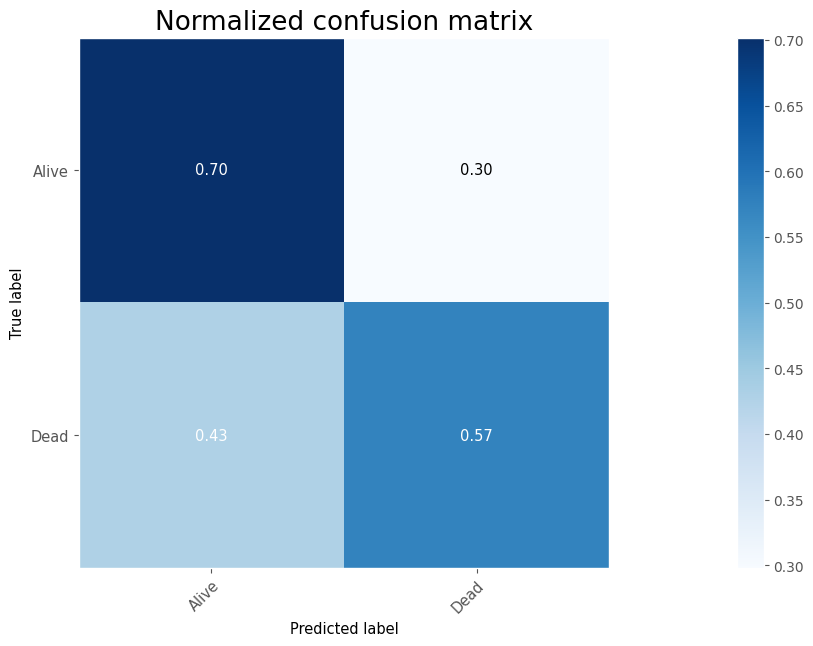

array([[0.70192308, 0.29807692],
       [0.42857143, 0.57142857]])

In [15]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Get prediction from model on validation data.
true_labels, predictions_labels, predict_probs, avg_epoch_loss = validation(test_dataloader, device)

# Convert predict_probs to a NumPy array
predict_probs = np.array(predict_probs)

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predict_probs[:, 1])  # Assuming the second column contains probabilities for the positive class.

# Calculate true positives, true negatives, false positives, false negatives
tn, fp, fn, tp = confusion_matrix(true_labels, predictions_labels).ravel()

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Show the evaluation report, ROC AUC score, and other metrics.
print("Evaluation Report:")
print(evaluation_report)
print("\nROC AUC Score:", roc_auc)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1)


In [16]:
help(plot_confusion_matrix)

Help on function plot_confusion_matrix in module ml_things.plot_functions:

plot_confusion_matrix(y_true, y_pred, use_title=None, classes='', normalize=False, style_sheet='ggplot', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f46eeef5cf0>, font_size=None, verbose=0, width=3, height=1, magnify=0.1, use_dpi=50, path=None, show_plot=True, **kwargs)
    This function prints and plots the confusion matrix.
    
    Normalization can be applied by setting `normalize=True`.
    
    Arguments:
    
        y_true (:obj:`list / np.ndarray`):
            List of labels values.
    
        y_pred (:obj:`list / np.ndarray`):
            List of predicted label values.
    
        use_title (:obj:`int`, `optional`):
            Title on top of plot. This argument is optional and it will have a `None` value attributed
            inside the function.
    
        classes (:obj:`str`, `optional`, defaults to :obj:``):
            List of label names. This argument is optional and i

In [17]:
def calculate_metrics(TP, TN, FP, FN):
    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Precision
    precision = TP / (TP + FP)
    
    # Recall (Sensitivity)
    recall = TP / (TP + FN)
    
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

accuracy, precision, recall, f1_score = calculate_metrics(tp, tn, fp, fn)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.6864406779661016
Precision: 0.20512820512820512
Recall: 0.5714285714285714
F1 Score: 0.3018867924528302


100%|██████████| 8/8 [00:02<00:00,  3.47it/s]


Evaluation Report:
              precision    recall  f1-score   support

       Alive       0.92      0.69      0.79        97
        Dead       0.33      0.71      0.45        21

    accuracy                           0.69       118
   macro avg       0.63      0.70      0.62       118
weighted avg       0.81      0.69      0.73       118


ROC AUC Score: 0.7275405007363771

True Positives: 15
True Negatives: 67
False Positives: 30
False Negatives: 6
Normalized confusion matrix


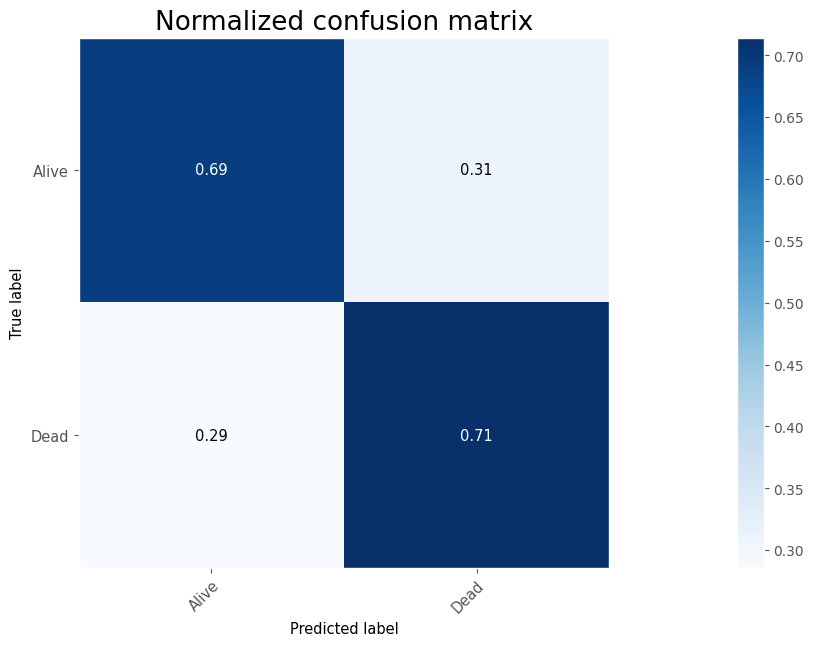

array([[0.69072165, 0.30927835],
       [0.28571429, 0.71428571]])

In [18]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Get prediction from model on validation data.
true_labels, predictions_labels, predict_probs, avg_epoch_loss = validation(valid_dataloader, device)

# Convert predict_probs to a NumPy array
predict_probs = np.array(predict_probs)

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predict_probs[:, 1])  # Assuming the second column contains probabilities for the positive class.

# Calculate true positives, true negatives, false positives, false negatives
tn, fp, fn, tp = confusion_matrix(true_labels, predictions_labels).ravel()

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))

# Show the evaluation report, ROC AUC score, and other metrics.
print("Evaluation Report:")
print(evaluation_report)
print("\nROC AUC Score:", roc_auc)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1)


In [19]:
def calculate_metrics(TP, TN, FP, FN):
    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Precision
    precision = TP / (TP + FP)
    
    # Recall (Sensitivity)
    recall = TP / (TP + FN)
    
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

accuracy, precision, recall, f1_score = calculate_metrics(tp, tn, fp, fn)

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Accuracy: 0.6949152542372882
Precision: 0.3333333333333333
Recall: 0.7142857142857143
F1 Score: 0.4545454545454545


In [20]:
# Save the model and tokenizer to a directory
output_dir = "saved_model/GPT2/"
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.


In [ ]:
output_dir = "saved_model/GPT2/"

In [ ]:
from transformers import GPT2ForSequenceClassification, GPT2Tokenizer

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)

# Load the model
model = GPT2ForSequenceClassification.from_pretrained(output_dir).to(device)

print("Model and tokenizer loaded successfully.")
